### Cyclistic: analysis for a bike sharing company

Yan Costa
<br>*July, 2021*

---    

##### **Mission statement**: Cyclistic is a bike-share program that features more than 5,800 bicycles and 600 docking stations across Chicago, IL (USA). The company currently has three distinct pricing plans: **single-ride passes**, **full-day passes**, and **annual memberships**. Their conclusion is that, financially speaking, 'annual members' are much more profitable than 'casual riders' - as they classify their customers. 
##### The idea behind this study is to analyze Cyclistic's user data and identify how customers behave differently, coming up with insights that could help convert 'casual riders' into 'annual members'.

---

##### The data analysis process consists of 6 key steps, them being: `Ask`, `Prepare`, `Process`, `Analyze`, `Share` and `Act`.
##### Each step and relevant finding is going to be documented. At the end, I am going to share at least **three key insights** to help achieve the business goal.

### Ask
#### At this point, it is important to have a clear understanding of what the business task is and what steps we plan to take to successfully tackle it. 
* The purpose of this analysis has already been clearly defined: **improve revenue by converting 'casual riders' into 'annual members'**. For that, we have to understand in what exactly they differ from each other, so that we can target these customers in marketing campaings. 
* The key **stakeholders** are the marketing analytics team, and the director of Marketing, to whom the results will be reported.

### Prepare
#### Ensure that the data source is reliable and its content allows for the analysis.
* The dataset comes from *Motivate International Inc.*, under a [data license agreement](https://www.divvybikes.com/data-license-agreement). Forked via this Kaggle [dataset](https://www.kaggle.com/kevinvenza/cyclistic-bike-share). It consists of 660mb+ of .csv files. Its integrity and credibility are secured, given that it comes directly from the source - company's own data.
* The files, as we will soon see, are well-organized and also follow a naming convention, which adds to its accessibility.




### Process
#### Description of the chosen tools and documentation of each step taken for data cleaning and manipulation
* The size of each file has played an important role in the choice of tools. Neither *BigQuery* (SQL, under a public license) nor *Google Sheets* were able to handle such amount of data. Therefore, I have chosen to use **Python** - and this Kaggle notebook - to perform the analysis. It should facilitate both manipulation and creation of visualizations when necessary.
* Each step of the **analysis** is thoroughly documented.

In [1]:
# main imports (for calculations and data manipulation)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# after glimpsing the data, I'll also import geopy to calculate the distance of each ride
from geopy import distance, Point

# to plot a map afterwards
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import Segment, ColumnDataSource

# get the path of each file and join them
import glob
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cyclistic-bike-share/202011-divvy-tripdata.csv
/kaggle/input/cyclistic-bike-share/202012-divvy-tripdata.csv
/kaggle/input/cyclistic-bike-share/202004-divvy-tripdata.csv
/kaggle/input/cyclistic-bike-share/202009-divvy-tripdata.csv
/kaggle/input/cyclistic-bike-share/202006-divvy-tripdata.csv
/kaggle/input/cyclistic-bike-share/202010-divvy-tripdata.csv
/kaggle/input/cyclistic-bike-share/202008-divvy-tripdata.csv
/kaggle/input/cyclistic-bike-share/202101-divvy-tripdata.csv
/kaggle/input/cyclistic-bike-share/202007-divvy-tripdata.csv
/kaggle/input/cyclistic-bike-share/202103-divvy-tripdata.csv
/kaggle/input/cyclistic-bike-share/202104-divvy-tripdata.csv
/kaggle/input/cyclistic-bike-share/202102-divvy-tripdata.csv
/kaggle/input/cyclistic-bike-share/202005-divvy-tripdata.csv


In [2]:
# Reading all the files in and putting them together under one dataframe, by the name of 'trip_data'
path = '/kaggle/input/cyclistic-bike-share/'
all_files = glob.glob(path + "*.csv")
trip_data = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# Info (details of the dataframe) and describe (stats for the numeric data) methods
trip_data.info()
trip_data.describe() # does not tell much, since most of the relevant data is not in numeric format

# First records of the dataframe
trip_data.head()

# Notes: from the start, we can note that the columns adhere to the snake case convention, which adds to its credibility and facilitates 
# manipulation. Moreover, I suppose that the 'ID' columns will not add much to the analysis as far as their content goes.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3826978 entries, 0 to 3826977
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 379.6+ MB


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BD0A6FF6FFF9B921,electric_bike,2020-11-01 13:36:00,2020-11-01 13:45:40,Dearborn St & Erie St,110.0,St. Clair St & Erie St,211.0,41.894177,-87.629127,41.894434,-87.623379,casual
1,96A7A7A4BDE4F82D,electric_bike,2020-11-01 10:03:26,2020-11-01 10:14:45,Franklin St & Illinois St,672.0,Noble St & Milwaukee Ave,29.0,41.890959,-87.635343,41.900675,-87.662480,casual
2,C61526D06582BDC5,electric_bike,2020-11-01 00:34:05,2020-11-01 01:03:06,Lake Shore Dr & Monroe St,76.0,Federal St & Polk St,41.0,41.880983,-87.616754,41.872054,-87.629550,casual
3,E533E89C32080B9E,electric_bike,2020-11-01 00:45:16,2020-11-01 00:54:31,Leavitt St & Chicago Ave,659.0,Stave St & Armitage Ave,185.0,41.895499,-87.682013,41.917744,-87.691392,casual
4,1C9F4EF18C168C60,electric_bike,2020-11-01 15:43:25,2020-11-01 16:16:52,Buckingham Fountain,2.0,Buckingham Fountain,2.0,41.876497,-87.620358,41.876448,-87.620338,casual


In [3]:
# Starting out the cleaning process, let's just confirm that there are no duplicates in the dataframe:

trip_data[trip_data.duplicated()]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual


In [4]:
# Next up: check if there's any NA values in this dataset and what percentage of the dataset they represent:

(trip_data.isna().sum() / len(trip_data)) * 100

ride_id               0.000000
rideable_type         0.000000
started_at            0.000000
ended_at              0.000000
start_station_name    3.873317
start_station_id      3.889675
end_station_name      4.479148
end_station_id        4.491194
start_lat             0.000000
start_lng             0.000000
end_lat               0.130782
end_lng               0.130782
member_casual         0.000000
dtype: float64

In [5]:
# Considering that the NAs only represent ~ 4.4% of the dataset - given that the highest percentages are all across the station names and IDs, 
# I suppose that they are the same records, and that shouldn't significantly impact the outcome of the project regardless -, I'll simply drop 
# them. 
# Since there are no duplicate entries, the 'ride_id' column would be rather useless for the purpose of this analysis. Same for the ID of each 
# station - their names are much more descriptive. With that said, I'll drop those columns as well and save the changes into a new dataframe.

trip_data = trip_data.dropna()
clean_trip_data = trip_data.drop(['ride_id', 'start_station_id', 'end_station_id'], axis=1)

# After exploring what the 'rideable_type' column represents (basically, if a bike is classic, eletric, or docked) and what are the unique 
# values, I'll create an alternate dataframe without the docked bikes, to be used later on for analysis.

trip_data['rideable_type'].unique()
bike_types = clean_trip_data.query("rideable_type == 'classic_bike' or rideable_type == 'electric_bike'")
bike_types.rideable_type.unique()

array(['electric_bike', 'classic_bike'], dtype=object)

### Manipulation / Transformation
* After cleaning the dataset, transformations are needed and documented in the following steps.  

In [6]:
clean_trip_data.head()

# Main steps: 

# 1. Format 'started_at' and 'ended_at' as datetime objects, which will then allow for calculations.

# 2. Create columns for: day of the week for each ride, duration of each ride, start hour of each ride.

# 3. Create columns for start and ending points of each ride (lat, lng). It will then enable to calculate the distance (in km) and
# coordinates, that are the needed input for 'bokeh' to be able to plot the maps.

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual
0,electric_bike,2020-11-01 13:36:00,2020-11-01 13:45:40,Dearborn St & Erie St,St. Clair St & Erie St,41.894177,-87.629127,41.894434,-87.623379,casual
1,electric_bike,2020-11-01 10:03:26,2020-11-01 10:14:45,Franklin St & Illinois St,Noble St & Milwaukee Ave,41.890959,-87.635343,41.900675,-87.662480,casual
2,electric_bike,2020-11-01 00:34:05,2020-11-01 01:03:06,Lake Shore Dr & Monroe St,Federal St & Polk St,41.880983,-87.616754,41.872054,-87.629550,casual
3,electric_bike,2020-11-01 00:45:16,2020-11-01 00:54:31,Leavitt St & Chicago Ave,Stave St & Armitage Ave,41.895499,-87.682013,41.917744,-87.691392,casual
4,electric_bike,2020-11-01 15:43:25,2020-11-01 16:16:52,Buckingham Fountain,Buckingham Fountain,41.876497,-87.620358,41.876448,-87.620338,casual


In [7]:
# Transformation

# 1. Format 'started_at' and 'ended_at' as datetime objects

clean_trip_data['started_at'] = pd.to_datetime(clean_trip_data['started_at'])
clean_trip_data['ended_at'] = pd.to_datetime(clean_trip_data['ended_at'])

# 2. Creating the columns

# 2.1 'Day of Week'
clean_trip_data['day_of_week'] = clean_trip_data['started_at'].dt.day_name()

# 2.2 'Duration'
clean_trip_data['duration'] = (clean_trip_data['ended_at'] - clean_trip_data['started_at']) / pd.Timedelta(minutes=1)

# 2.3 'Start hour'
clean_trip_data['start_hour'] = clean_trip_data['started_at'].dt.hour

# Checking:
clean_trip_data.head()

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,day_of_week,duration,start_hour
0,electric_bike,2020-11-01 13:36:00,2020-11-01 13:45:40,Dearborn St & Erie St,St. Clair St & Erie St,41.894177,-87.629127,41.894434,-87.623379,casual,Sunday,9.666667,13
1,electric_bike,2020-11-01 10:03:26,2020-11-01 10:14:45,Franklin St & Illinois St,Noble St & Milwaukee Ave,41.890959,-87.635343,41.900675,-87.662480,casual,Sunday,11.316667,10
2,electric_bike,2020-11-01 00:34:05,2020-11-01 01:03:06,Lake Shore Dr & Monroe St,Federal St & Polk St,41.880983,-87.616754,41.872054,-87.629550,casual,Sunday,29.016667,0
3,electric_bike,2020-11-01 00:45:16,2020-11-01 00:54:31,Leavitt St & Chicago Ave,Stave St & Armitage Ave,41.895499,-87.682013,41.917744,-87.691392,casual,Sunday,9.250000,0
4,electric_bike,2020-11-01 15:43:25,2020-11-01 16:16:52,Buckingham Fountain,Buckingham Fountain,41.876497,-87.620358,41.876448,-87.620338,casual,Sunday,33.450000,15


In [8]:
# Importing to ignore the warning for the following action.

import warnings
warnings.filterwarnings('ignore')

In [9]:
%%timeit

# 3. Calculating the distance

'''
The 'Point()' method from geopy basically converts each lat and lng into an object of its own that allows for calculations of distances
later on. However, the 'distance' method - which is what actually interests - can function receiving a tuple as well. Thus, we'll calculate 
the time for each ('Point' vs a list comprehension) using a small sample set. Each has to be done in a separete cell, because of the %time it
magic function. Whichever is faster will be then passed into the entire dataframe.
'''

# Slice of the dataframe:
test_set = clean_trip_data.head(30)

# Geopy:
test_set['start_point_geo'] = test_set.apply(lambda row: Point(latitude=row['start_lat'], longitude=row['start_lng']), axis=1)
test_set['end_point_geo'] = test_set.apply(lambda row: Point(latitude=row['end_lat'], longitude=row['end_lng']), axis=1)

5.34 ms ± 40.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%%timeit

# Slice of the dataframe:
test_set = clean_trip_data.head(30)

# List comprehension:
test_set['start_point_lc'] = [tuple(l) for l in test_set[['start_lat', 'start_lng']].to_numpy()]
test_set['end_point_lc'] = [tuple(l) for l in test_set[['end_lat', 'end_lng']].to_numpy()]

## Considering the results, we will proceed to use the list comprehension.

3.09 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
# 3.1. Creating the points 

clean_trip_data['start_point'] = [tuple(l) for l in clean_trip_data[['start_lat', 'start_lng']].to_numpy()]
clean_trip_data['end_point'] = [tuple(l) for l in clean_trip_data[['end_lat', 'end_lng']].to_numpy()]

# 3.2. Creating a column for the distance in km
clean_trip_data['distance'] = clean_trip_data.apply(lambda row: distance.distance(row['start_point'], row['end_point']).km, axis=1)

In [12]:
# 3.3. Creating the coordinates
# We'll see later, through a visualization, that the top five stations for start and finishing trips of 'casual' customers are 'Streeter Dr & 
# Grand Ave', 'Lake Shore Dr & Monroe St', 'Millennium Park', 'Theater on the Lake' and 'Michigan Ave & Oak St'.
# With this info in mind, I'll create a dataframe that only contains a sample of 200 of these trips, where the start station is one of these. 
# Based on that, we will later plot a map of these routes. 

trip_coord = clean_trip_data[(clean_trip_data['member_casual'] == 'casual') & (clean_trip_data['rideable_type'] != 'docked_bike')]
trip_coord = trip_coord.query("start_station_name == 'Streeter Dr & Grand Ave' or start_station_name == 'Lake Shore Dr & Monroe St' or start_station_name == 'Millennium Park' or start_station_name == 'Theater on the Lake' or start_station_name == 'Michigan Ave & Oak St'").sample(200)

# A function to transform each point into a coordinate, formatted for the plotting. 
import math
from ast import literal_eval
def merc(Coords):
    Coordinates = literal_eval(Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

# Coordinates (0 indicates the starting point and 1 the ending point. x stands for lat and y stands for lng). 
trip_coord['coords_x0'] = trip_coord['start_point'].astype(str).apply(lambda x: merc(x)[0])
trip_coord['coords_y0'] = trip_coord['start_point'].astype(str).apply(lambda x: merc(x)[1])
trip_coord['coords_x1'] = trip_coord['end_point'].astype(str).apply(lambda x: merc(x)[0])
trip_coord['coords_y1'] = trip_coord['end_point'].astype(str).apply(lambda x: merc(x)[1])

### Analyze
#### Now that the data is finally clean, it is time to dive into it, perform calculations and identify trends and relationships that convey meaningful insights and ideas.
* I have chosen to demonstrate calculations and visualizations all together. It makes more sense for documentation and to actually see the idea behind each insight.
* The question to keep in mind derives from our business task: **based on their behavior, what could lead a 'casual' user to become an annual member?'**

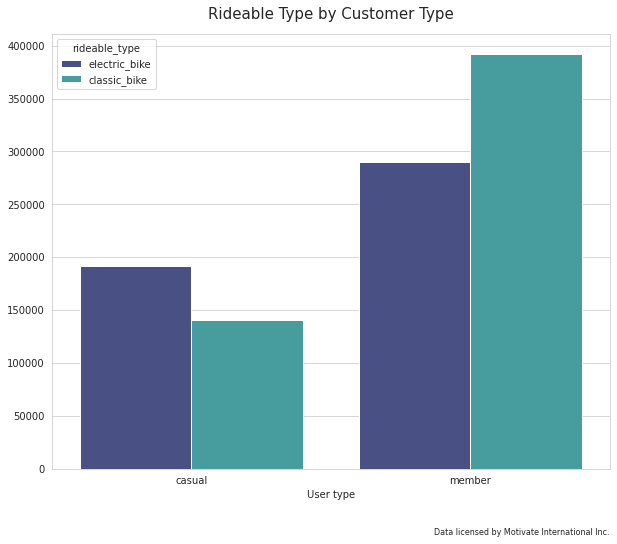

In [13]:
'''
Topics to be explored:
1. Most popular bikes by customer type
2. Top 5 stations (start and end) that 'casual' customers use the most (may allow for Out of Home advertising at the location or nearby)
3. Number of rides by user type in each day of the week
4. Busiest starting hour by type of customer
5. Average duration of each ride by user typer
6. Average distance of each ride by user type
7. Map for most popular routes of the casual customer  
'''

# 1. Most popular bikes by type of customer

plt.figure(figsize=(10, 8))
sns.set_style('whitegrid')
sns.countplot(data=bike_types, x='member_casual', hue='rideable_type', palette='mako');
plt.title('Rideable Type by Customer Type', fontdict={'fontsize': 15}, y=1.02);
plt.xlabel('User type');
plt.ylabel(None);
plt.figtext(0.9, 0.01, 'Data licensed by Motivate International Inc.', wrap=True, horizontalalignment='right', fontsize=8);

# Notes: through the following viz, we can clearly see that the proportion of casual customers using eletric bikes compared to members is
# significant. There are a number of factors that could be behind this - pricing, availability, etc. By the data we have, though, the only
# safe deduction is that casual customers tend to prefer eletric bikes.

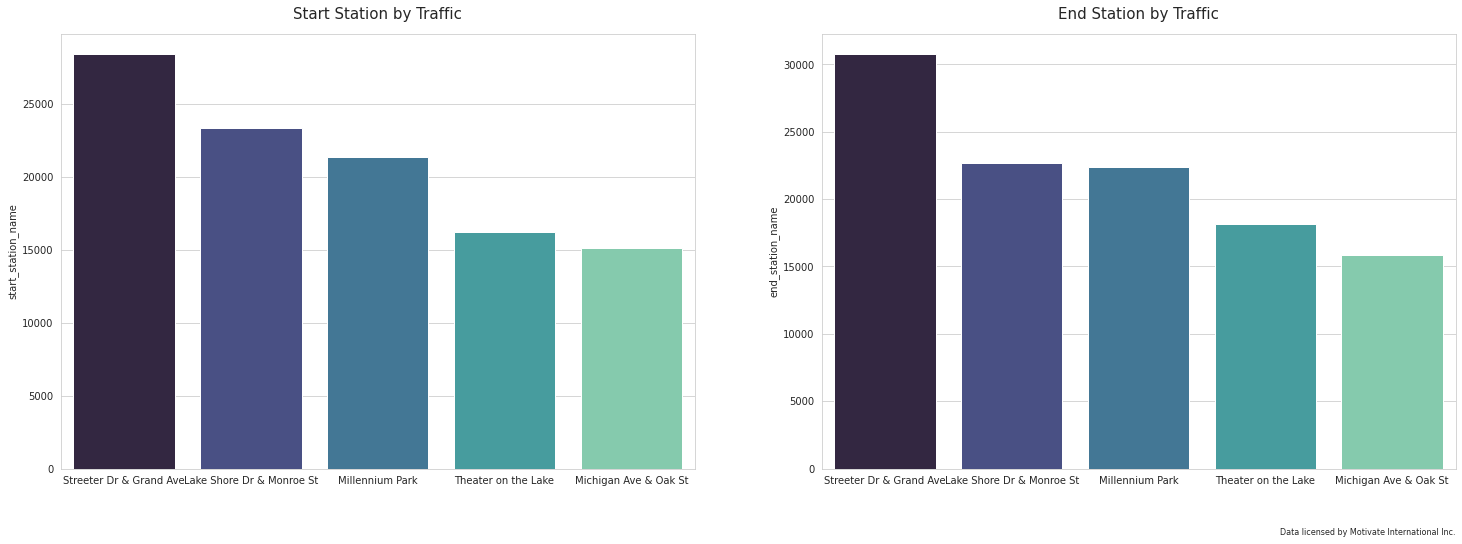

In [14]:
# 2. Top 5 stations that casual customers use the most

top_st_start = pd.DataFrame(clean_trip_data[clean_trip_data['member_casual'] == 'casual'].start_station_name.
                            value_counts().sort_values(ascending=False).head(5))
top_st_end = pd.DataFrame(clean_trip_data[clean_trip_data['member_casual'] == 'casual'].end_station_name.
                          value_counts().sort_values(ascending=False).head(5))

fig, axs = plt.subplots(ncols=2, figsize=(25, 8))
axs[0].set_title('Start Station by Traffic', fontdict={'fontsize': 15}, y=1.02);
axs[1].set_title('End Station by Traffic', fontdict={'fontsize': 15}, y=1.02);
sns.barplot(data=top_st_start, x=top_st_start.index, y='start_station_name', ax=axs[0], palette='mako');
sns.barplot(data=top_st_end, x=top_st_end.index, y='end_station_name', ax=axs[1], palette='mako');
plt.figtext(0.9, 0.01, 'Data licensed by Motivate International Inc.', wrap=True, horizontalalignment='right', fontsize=8);

# Notes: the busiest stations for casual users are very well defined. That allows for our marketing team to survey what would be the best 
# options in terms of position and pricing to place 'out of home' advertisements - either on the stations or nearby.

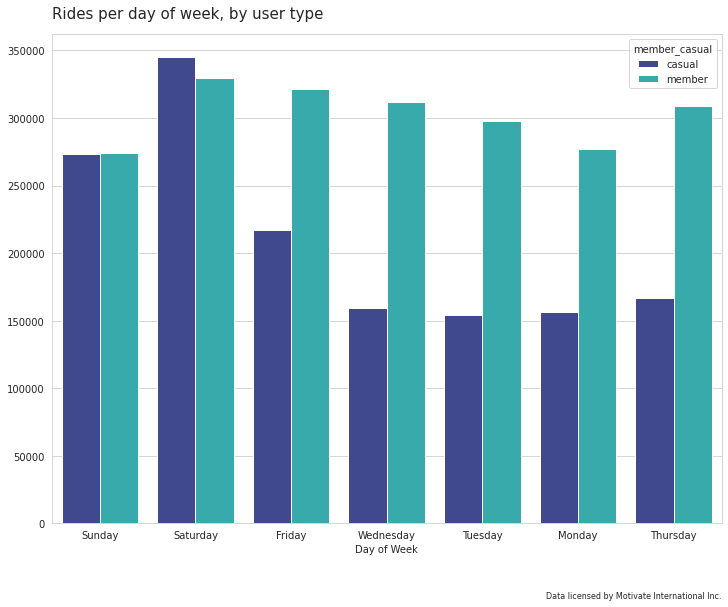

In [15]:
# 3. Number of rides by user type in each day of the week

plt.figure(figsize=(12, 9))
sns.countplot(data=clean_trip_data, x='day_of_week', hue='member_casual', palette='mako', saturation=1);
plt.title('Rides per day of week, by user type', loc='left', fontdict={'fontsize': 15}, y=1.02);
plt.xlabel('Day of Week');
plt.ylabel(None);
plt.figtext(0.9, 0.01, 'Data licensed by Motivate International Inc.', wrap=True, horizontalalignment='right', fontsize=8);

# Notes: there's a clear increase of casual members' usage on Friday and weekends, whilst annual members tend to have a more steady activity
# throughout the week. It's also safe to assume that once casual customers become annual members, they should adopt a similar behavior.
# Our marketing team could use this information to prompt these customers (e.g. sending an e-mail marketing on Thursday or Friday).

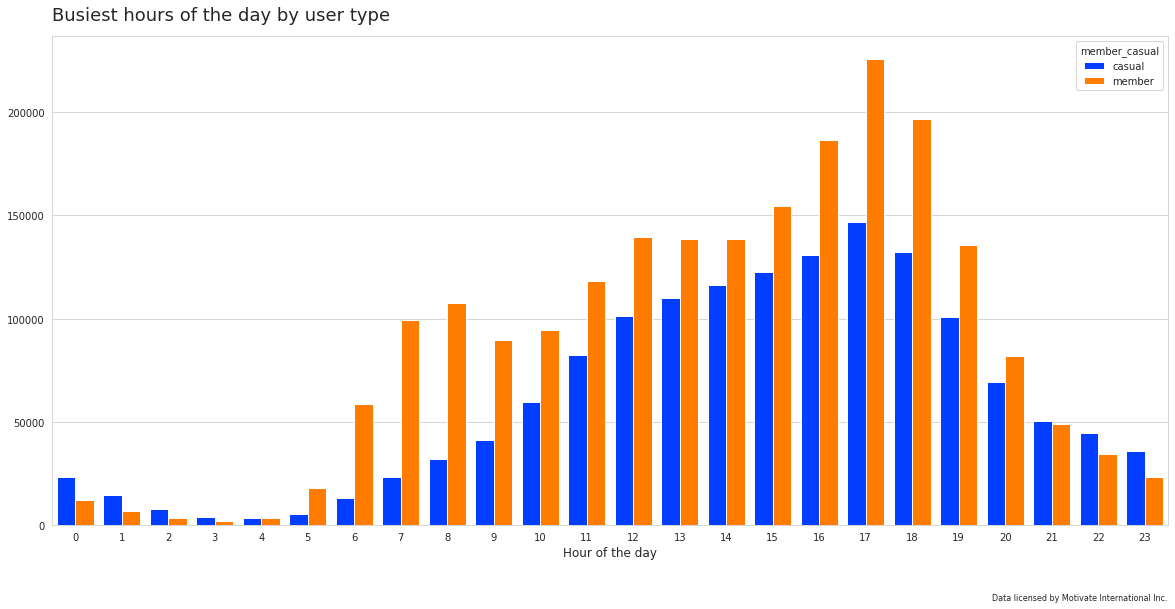

In [16]:
# 4. Busiest starting hour by type of customer

plt.figure(figsize=(20, 9))
sns.countplot(data=clean_trip_data, x='start_hour', hue='member_casual', palette='bright', saturation=1);
plt.title('Busiest hours of the day by user type', loc='left', fontdict={'fontsize': 18}, y=1.02);
plt.xlabel('Hour of the day', fontdict={'fontsize': 12});
plt.ylabel(None);
plt.figtext(0.9, 0.01, 'Data licensed by Motivate International Inc.', wrap=True, horizontalalignment='right', fontsize=8);

# Notes: the usage pattern of casual members seems normally distributed yet slightly left skewed. In other words, as the day goes by, the 
# number of rides increase even more for this user type. The range between 12pm-7pm should be the most fruitful for marketing campaigns in loco.

In [17]:
# Before plotting the graphs 5 (Average duration of each ride by type of customer) and 6 (Average distance of each ride by type of customer),
# I believe it would be useful to visualize it in a dataframe format:

clean_trip_data.groupby('member_casual').mean()[['duration', 'distance']].transpose()

# The mean distance between casual and annual members is almost identical. The mean duration, however, is significantly different - the unit
# of measure is minutes. One reason behind this might be that as casual customers tend to have a higher usage on the weekends, so they are less 
# attached to the duration of their rides. Or even that some people use it for longer rides (perhaps with family and/or friends) and it ends up 
# skewing the average.

member_casual,casual,member
duration,43.690969,12.241975
distance,2.150786,2.250423


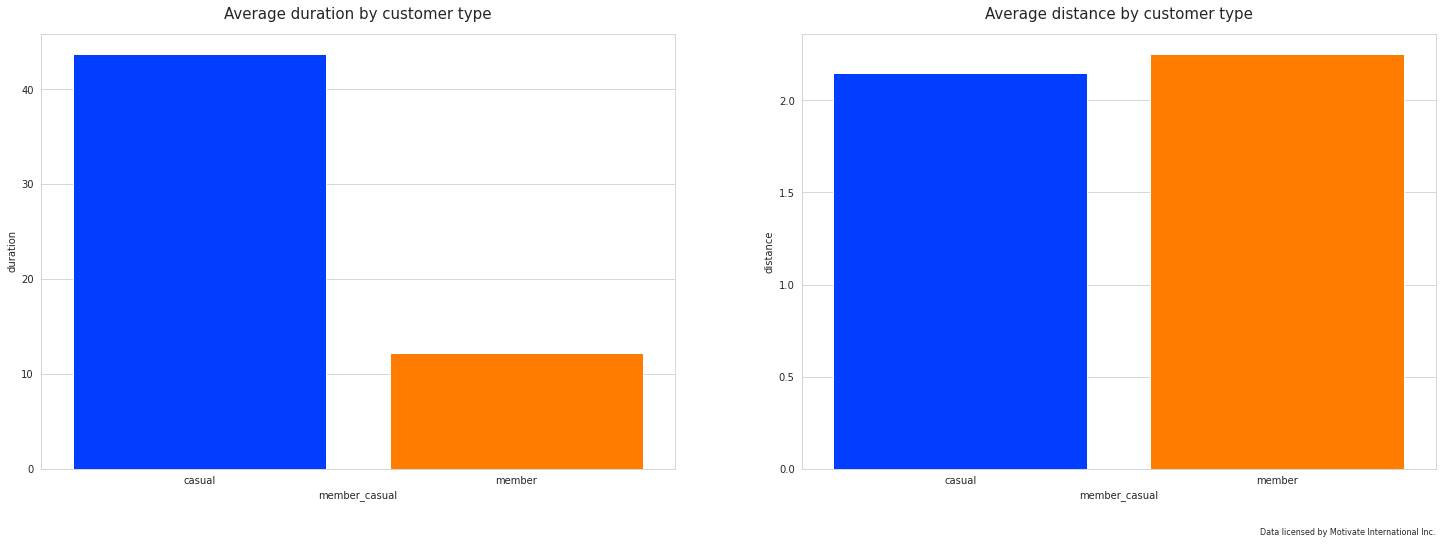

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(25, 8))
axs[0].set_title('Average duration by customer type', fontdict={'fontsize': 15}, y=1.02);
axs[1].set_title('Average distance by customer type', fontdict={'fontsize': 15}, y=1.02);

# 5. Average duration of each ride by type of customer

data = clean_trip_data.groupby('member_casual').mean()[['duration', 'distance']]
sns.barplot(data=data, x=data.index, y='duration', ax=axs[0], palette='bright', saturation=1);

# 6. Average distance of each ride by type of customer

sns.barplot(data=data, x=data.index, y='distance', ax=axs[1], palette='bright', saturation=1);

plt.figtext(0.9, 0.01, 'Data licensed by Motivate International Inc.', wrap=True, horizontalalignment='right', fontsize=8);

In [19]:
# 7. Map for most popular routes of the casual customer
# The map is interactive - with zooming tools and a reset button to come back to the original plot. 

p = figure(x_range=(-9780000, -9745000), y_range=(5130000, 5160000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(get_provider('CARTODBPOSITRON'))

source = ColumnDataSource(dict(
        x=trip_coord['coords_x0'],
        y=trip_coord['coords_y0'],
        xm01=trip_coord['coords_x1'],
        ym01=trip_coord['coords_y1'],
    )
)

glyph = Segment(x0="x", y0="y", x1="xm01", y1="ym01", line_color="#f4a582", line_width=4, line_alpha=.2, line_join='miter', line_cap='round')
p.add_glyph(source, glyph)
p.title.text = 'Most popular routes for casual users'
p.title.align = 'left'
p.title.text_color= 'black'
p.title.text_font_size = '20px'

output_notebook()
show(p)

# Notes: this plot only enhances the profile of the 'casual' user and its contrast to the annual member. It is safe to assume that most casual 
# users are people that use the services mainly on weekends, prefer eletric bike and ride mainly in the city centre. These people tend to favor 
# leisure or perhaps are tourists, but don't usually commute using our bikes. They are probably sightseeing and as a result, they end up using
# the bikes for a longer period, even though the average distance is similar to that of the annual member.

Loading BokehJS ...

### Share and Act
#### With the data visualizations create throughout the analysis, it's time to share the findings and the story the data tells.
#### Even though the task is simply to identify differences between user types, considering all of the following questions may be useful to convey valuable recommendations:

1. **How do annual members and casual riders use Cyclistic bikes differently?**
*  As described in the previous - and last - plot notes, the profile for each customer and its effect on the way they use our services is quite clear - obviously, more data would be important to determine if our inferences are actually accurate. 
* **Casual** customers are tend to prefer electric bikes, usually ride near the city centre - as demonstrate via the map and most frequent stations plots -, have higher usage on weekends and in the afternoon and usually have longer rides - maybe because they are on their time off and focused on leisure, sightseeing, etc. Of course, some of them may actually commute during working days but have not been triggered to sign for an annual membership. There could be strategies for both personas.
* **Annual** members not necessary prefer one type of bike over the other - even though they, in general, use more of the classic bikes, it may only be due to availability. Because of their steady usage on working days and the peak around the end of business hours, they probably make the most use of our services to move to and from their working place. As a result of their annual membership, they probably use the bikes for shorter distances, which would reasonably explain the difference in the duration of their trips. 

2. **Why would casual riders buy Cyclistic annual memberships?**
* Two main pieces of data, which are missing, could contribute to tackle this question: out of the docked bikes, which are electric and which are 'classic'? A higher availability of electric bikes in the busiest stations for casual customers could drive their usage up. Also, financial information could help emphasize the benefits of being an annual member. For those casual clients who use the bikes with a certain frequency, highlighting the cost-benefit of being an annual member might make them consider becoming one.

3. **How can Cyclistic use digital media to influence casual riders to become members?**
* The brand could try to drive up engagement by making posts related to leisure (especially closer to the weekend) and the benefits of using riding a bicycle on a daily basis - these could be related to the environment (less cars on the street), physical and mental health (avoid traffic, exercising, etc.)
* Mentioning the benefits of being an annual member should also be effective.

### *<ins>Recommendations</ins>* (top three):
##### 1. Use social media and e-mail marketing to engane with casual customers. Emphasize the benefits of being an annual member, which they may not be acquainted with yet. 
##### 1.1 Give a special discount valid for working days for those who use frequently the services only on weekends. The percentage of this discount may gradually decrease throughout the day - which would mean that the earlier they used their coupon, the higher the percentage would be. This may lead them to use it early in the morning, which is currently their bottom in daily usage.<br>
##### 2. Ensure availability of electric bikes on the most popular stations.<br> 
##### 3. Place 'out of home' ads near these stations and on their most frequent routes, especially in the city centre and close to tourist attractions.

### Thank you for reading!
##### You can find me on:
* [Github](https://github.com/yncosta)
* [Kaggle](https://www.kaggle.com/yanscosta)
* [LinkedIn](https://www.linkedin.com/in/yanphcosta/)